In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras import backend as K
from sklearn.utils import class_weight
import numpy as np

# Data Preprocessing
# Replace 'train_dir' and 'val_dir' with the paths to your actual train and validation directories
train_dir = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/train'
val_dir = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/val'
test_dir = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes)

# Create a dictionary to pass it to the training function
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# VGG16 Model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

# ResNet50 Model
resnet_model = ResNet50(weights='imagenet', include_top=False)
for layer in resnet_model.layers[:-4]:
    layer.trainable = False  # Freeze layers

# Adapt the output of VGG16 to the input of ResNet50
x = vgg_model.output
x = Conv2D(3, (1, 1), padding='same')(x)  # 1x1 Conv to reduce to 3 channels
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Now feed this into ResNet50
x = resnet_model(x)

# Continue with your architecture
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Additional Dense layer
x = Dense(5, activation='softmax')(x)  # 5 classes for KL grades 0-4

combined_model = Model(inputs=vgg_model.input, outputs=x)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Compile the model
opt = Adam(learning_rate=0.001)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score]
combined_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

# Training settings
batch_size = 32
epochs = 30

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Create a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001, verbose=1)

# Add ReduceLROnPlateau to the list of callbacks
callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weight_dict,  # Add this line for class weights
    callbacks=callbacks_list)

# Save the model in h5 format
# combined_model.save('/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/image_classification/vgg16_resnet/final_model.h5')


Found 7894 images belonging to 5 classes.
Found 2941 images belonging to 5 classes.
Found 3772 images belonging to 5 classes.


Epoch 1/30


2023-10-12 11:13:49.320010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - ETA: 0s - loss: 1.4479 - accuracy: 0.3161 - precision_2: 0.4960 - recall_2: 0.0553 - f1_score: 0.0961

2023-10-12 11:18:38.732650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.41690, saving model to best_model.h5


/Users/senu2k/anaconda3/envs/flaskenv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 368s 1s/step - loss: 1.4479 - accuracy: 0.3161 - precision_2: 0.4960 - recall_2: 0.0553 - f1_score: 0.0961 - val_loss: 2.9466 - val_accuracy: 0.4169 - val_precision_2: 0.4169 - val_recall_2: 0.4169 - val_f1_score: 0.4169 - lr: 0.0010
Epoch 2/30
246/246 [==============================] - ETA: 0s - loss: 1.3233 - accuracy: 0.3817 - precision_2: 0.5830 - recall_2: 0.1010 - f1_score: 0.1682
Epoch 2: val_accuracy improved from 0.41690 to 0.41724, saving model to best_model.h5
246/246 [==============================] - 337s 1s/step - loss: 1.3233 - accuracy: 0.3817 - precision_2: 0.5830 - recall_2: 0.1010 - f1_score: 0.1682 - val_loss: 7.9703 - val_accuracy: 0.4172 - val_precision_2: 0.4172 - val_recall_2: 0.4172 - val_f1_score: 0.4172 - lr: 0.0010
Epoch 3/30
246/246 [==============================] - ETA: 0s - loss: 1.2964 - accuracy: 0.4013 - precision_2: 0.5956 - recall_2: 0.1339 - f1_score: 0.2149
Epoch 3: val_accuracy did not improve from 0.417

In [5]:
combined_model.save('/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/image_classification/vgg16_resnet/final_model.h5')

118/118 [==============================] - 60s 498ms/step - loss: 0.8411 - accuracy: 0.6429 - precision_2: 0.7157 - recall_2: 0.5559 - f1_score: 0.5913
Test Loss: 0.841114342212677
Test Accuracy: 0.6428950428962708
Test Precision: 0.7156996726989746
Test Recall: 0.5559384822845459
Test F1 Score: 0.5912910103797913


2023-10-12 14:21:16.359492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 70s 582ms/step


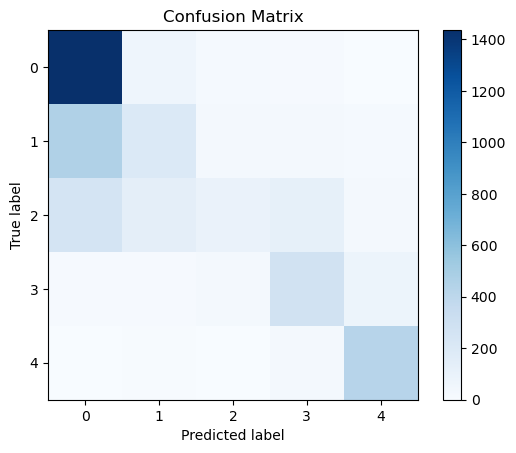

In [7]:
evaluation_metrics = combined_model.evaluate(test_generator)
print("Test Loss:", evaluation_metrics[0])
print("Test Accuracy:", evaluation_metrics[1])
print("Test Precision:", evaluation_metrics[2])
print("Test Recall:", evaluation_metrics[3])
print("Test F1 Score:", evaluation_metrics[4])



# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.show()

# Evaluate on test data and plot confusion matrix
y_pred = np.argmax(combined_model.predict(test_generator), axis=-1)
y_true = test_generator.classes
plot_confusion_matrix(y_true, y_pred, classes=test_generator.class_indices.keys())

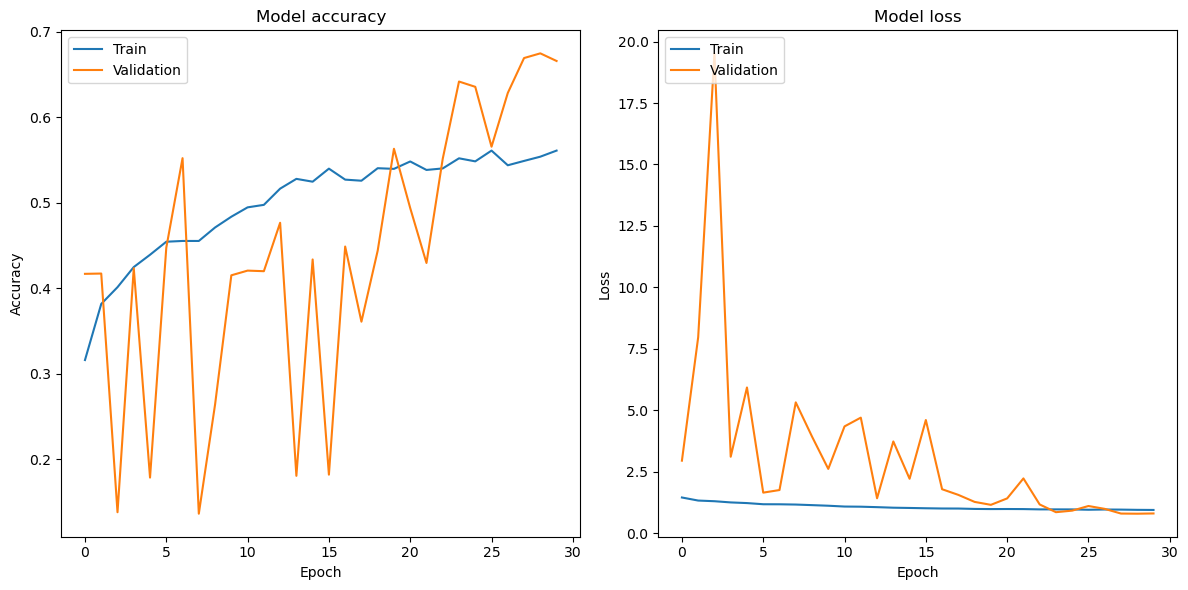

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
print("True labels:", y_true)
print("Predicted labels:", y_pred)
print("Class indices:", test_generator.class_indices)
print("Shape of y_true:", np.shape(y_true))
print("Shape of y_pred:", np.shape(y_pred))

True labels: [0 0 0 ... 4 4 4]
Predicted labels: [0 0 1 ... 4 4 4]
Class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Shape of y_true: (3772,)
Shape of y_pred: (3772,)


In [10]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:", cm)
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Add text annotations to the cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    
    plt.show()



Confusion Matrix: [[1436   67   22   12    0]
 [ 458  200   27   31   20]
 [ 254  140   95  120   29]
 [  14   13   23  272   76]
 [   0    8    1   32  422]]


118/118 [==============================] - 58s 489ms/step


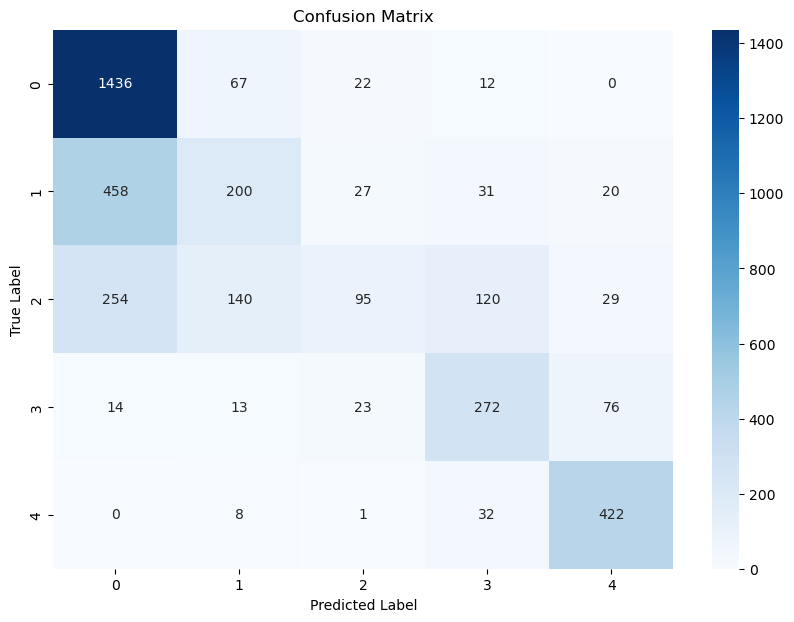

In [12]:
import seaborn as sns  # Import seaborn for better visualization

# ... (rest of your code)

# Generate predictions
Y_pred = combined_model.predict(test_generator, steps=test_generator.n // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
